# Radio Map 补全任务 - UNet 架构

## 方法说明
使用优化的UNet架构进行Radio Map补全任务，包含以下特性：
- **改进的UNet架构**：添加注意力机制和残差连接
- **混合损失函数**：结合L1、L2损失和结构相似性损失
- **固定遮罩训练**：使用与测试集相同的144个固定遮罩位置，确保训练和测试分布一致
- **数据增强**：轻微噪声和亮度调整（但保持遮罩位置不变）
- **渐进式学习策略**：学习率调度和梯度裁剪

## 1. 环境配置和导入库

In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')

Using device: cuda
GPU: NVIDIA GeForce RTX 5090
Memory: 31.36 GB


## 2. 数据路径配置

In [2]:
TRAIN_PATH = os.path.join('Data', 'train')
TEST_PATH = os.path.join('Data', 'test(student)')
MASK_PATH = os.path.join(TEST_PATH, 'mask.csv')

OUTPUT_PATH = 'output_unet'
MODEL_PATH = 'models_unet'
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

print(f"训练数据路径: {TRAIN_PATH}")
print(f"测试数据路径: {TEST_PATH}")
print(f"遮罩文件路径: {MASK_PATH}")

训练数据路径: Data/train
测试数据路径: Data/test(student)
遮罩文件路径: Data/test(student)/mask.csv


## 3. 数据加载和预处理

In [3]:
def load_masks(mask_path):
    """加载遮罩坐标"""
    masks = []
    with open(mask_path, 'r') as f:
        for line in f:
            coords = line.strip().split(',')
            if len(coords) == 4:
                masks.append([int(x) for x in coords])
    return masks

def apply_masks_to_image(img, masks, fill_value=0.5):
    """对图像应用遮罩"""
    img_masked = img.copy()
    mask_binary = np.ones_like(img)
    
    for mask in masks:
        x1, y1, x2, y2 = mask
        img_masked[y1:y2+1, x1:x2+1] = fill_value
        mask_binary[y1:y2+1, x1:x2+1] = 0
    
    return img_masked, mask_binary

class RadioMapDataset(Dataset):
    """Radio Map数据集"""
    def __init__(self, data_path, masks=None, mode='train', transform=None, augment=False):
        self.data_path = data_path
        self.masks = masks
        self.mode = mode
        self.transform = transform
        self.augment = augment and mode == 'train'
        
        # 获取所有图像文件
        self.image_files = sorted([f for f in os.listdir(data_path) if f.endswith('.png')])
        
        # 划分训练集和验证集
        if mode == 'train':
            n_train = int(len(self.image_files) * 0.9)
            self.image_files = self.image_files[:n_train]
        elif mode == 'val':
            n_train = int(len(self.image_files) * 0.9)
            self.image_files = self.image_files[n_train:]
            
        print(f"{mode} dataset size: {len(self.image_files)}")
    
    def __len__(self):
        return len(self.image_files)
    
    def augment_image(self, img):
        """数据增强：添加轻微噪声和亮度变化"""
        if random.random() > 0.5:
            # 添加高斯噪声
            noise = np.random.normal(0, 0.005, img.shape)
            img = np.clip(img + noise, 0, 1)
        if random.random() > 0.5:
            # 亮度调整
            brightness = random.uniform(0.98, 1.02)
            img = np.clip(img * brightness, 0, 1)
        return img
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_path, self.image_files[idx])
        img = Image.open(img_path).convert('L')
        img = np.array(img, dtype=np.float32) / 255.0
        
        # 数据增强
        if self.augment:
            img = self.augment_image(img)
        
        if self.mode in ['train', 'val']:
            # 训练和验证模式 - 使用与测试集相同的固定遮罩
            if self.masks:
                # 始终使用固定的144个遮罩，这样训练和测试分布一致
                img_masked, mask_binary = apply_masks_to_image(img, self.masks, fill_value=0.5)
            else:
                # 如果没有提供遮罩，报错（因为必须使用固定遮罩）
                raise ValueError("训练时必须提供遮罩文件")
            
            img_tensor = torch.from_numpy(img.astype(np.float32)).unsqueeze(0)
            img_masked_tensor = torch.from_numpy(img_masked.astype(np.float32)).unsqueeze(0)
            mask_tensor = torch.from_numpy(mask_binary.astype(np.float32)).unsqueeze(0)
            
            return {
                'input': img_masked_tensor,
                'target': img_tensor,
                'mask': mask_tensor,
                'filename': self.image_files[idx]
            }
        else:
            # 测试模式
            if self.masks:
                img_masked, mask_binary = apply_masks_to_image(img, self.masks, fill_value=0.5)
            else:
                img_masked = img
                mask_binary = np.ones_like(img)
            
            img_tensor = torch.from_numpy(img.astype(np.float32)).unsqueeze(0)
            img_masked_tensor = torch.from_numpy(img_masked.astype(np.float32)).unsqueeze(0)
            mask_tensor = torch.from_numpy(mask_binary.astype(np.float32)).unsqueeze(0)
            
            return {
                'input': img_masked_tensor,
                'original': img_tensor,
                'mask': mask_tensor,
                'filename': self.image_files[idx]
            }

# 加载遮罩
masks = load_masks(MASK_PATH)
print(f"加载了 {len(masks)} 个遮罩")
print(f"第一个遮罩坐标: {masks[0]}")
print("注意：训练将使用与测试集相同的固定144个遮罩，确保训练和测试分布一致")

加载了 144 个遮罩
第一个遮罩坐标: [3, 3, 13, 13]
注意：训练将使用与测试集相同的固定144个遮罩，确保训练和测试分布一致


## 4. 优化的 UNet 架构

In [4]:
class AttentionBlock(nn.Module):
    """注意力机制模块"""
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class ResidualConvBlock(nn.Module):
    """带残差连接的卷积块"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualConvBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv_block(x)
        out += residual
        out = self.relu(out)
        return out


class ImprovedUNet(nn.Module):
    """改进的UNet架构，包含注意力机制和残差连接"""
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512, 1024]):
        super(ImprovedUNet, self).__init__()
        
        self.encoder1 = ResidualConvBlock(in_channels, features[0])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder2 = ResidualConvBlock(features[0], features[1])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder3 = ResidualConvBlock(features[1], features[2])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder4 = ResidualConvBlock(features[2], features[3])
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 瓶颈层
        self.bottleneck = ResidualConvBlock(features[3], features[4])
        
        # 解码器部分
        self.upconv4 = nn.ConvTranspose2d(features[4], features[3], kernel_size=2, stride=2)
        self.att4 = AttentionBlock(F_g=features[3], F_l=features[3], F_int=features[3]//2)
        self.decoder4 = ResidualConvBlock(features[4], features[3])
        
        self.upconv3 = nn.ConvTranspose2d(features[3], features[2], kernel_size=2, stride=2)
        self.att3 = AttentionBlock(F_g=features[2], F_l=features[2], F_int=features[2]//2)
        self.decoder3 = ResidualConvBlock(features[3], features[2])
        
        self.upconv2 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=features[1], F_l=features[1], F_int=features[1]//2)
        self.decoder2 = ResidualConvBlock(features[2], features[1])
        
        self.upconv1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=features[0], F_l=features[0], F_int=features[0]//2)
        self.decoder1 = ResidualConvBlock(features[1], features[0])
        
        # 输出层
        self.final_conv = nn.Sequential(
            nn.Conv2d(features[0], features[0]//2, kernel_size=3, padding=1),
            nn.BatchNorm2d(features[0]//2),
            nn.ReLU(inplace=True),
            nn.Conv2d(features[0]//2, out_channels, kernel_size=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # 编码器
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        # 瓶颈
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        # 解码器
        dec4 = self.upconv4(bottleneck)
        enc4 = self.att4(g=dec4, x=enc4)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        enc3 = self.att3(g=dec3, x=enc3)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        enc2 = self.att2(g=dec2, x=enc2)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        enc1 = self.att1(g=dec1, x=enc1)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return self.final_conv(dec1)


# 测试模型
def test_model():
    model = ImprovedUNet(in_channels=1, out_channels=1)
    model = model.to(device)
    
    test_input = torch.randn(2, 1, 256, 256).to(device)
    
    with torch.no_grad():
        output = model(test_input)
    
    print(f"输入尺寸: {test_input.shape}")
    print(f"输出尺寸: {output.shape}")
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"总参数量: {total_params:,}")
    print(f"可训练参数量: {trainable_params:,}")

test_model()

输入尺寸: torch.Size([2, 1, 256, 256])
输出尺寸: torch.Size([2, 1, 256, 256])
总参数量: 32,813,933
可训练参数量: 32,813,933


## 5. 损失函数定义

In [5]:
class CombinedLoss(nn.Module):
    """组合损失函数：L1 + L2 + SSIM"""
    def __init__(self, l1_weight=0.5, l2_weight=0.5, ssim_weight=0.0):
        super(CombinedLoss, self).__init__()
        self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        self.ssim_weight = ssim_weight
        
        self.l1_loss = nn.L1Loss()
        self.l2_loss = nn.MSELoss()
        
    def gaussian_kernel(self, size=11, sigma=1.5, channels=1):
        """创建高斯核用于SSIM"""
        kernel = torch.tensor(
            [[np.exp(-((x - size // 2) ** 2 + (y - size // 2) ** 2) / (2 * sigma ** 2))
              for x in range(size)] for y in range(size)],
            dtype=torch.float32
        )
        kernel = kernel / kernel.sum()
        kernel = kernel.unsqueeze(0).unsqueeze(0).repeat(channels, 1, 1, 1)
        return kernel
    
    def ssim_loss(self, pred, target, window_size=11, C1=0.01**2, C2=0.03**2):
        """计算SSIM损失"""
        window = self.gaussian_kernel(window_size).to(pred.device)
        
        mu1 = F.conv2d(pred, window, padding=window_size//2, groups=1)
        mu2 = F.conv2d(target, window, padding=window_size//2, groups=1)
        
        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2
        
        sigma1_sq = F.conv2d(pred * pred, window, padding=window_size//2, groups=1) - mu1_sq
        sigma2_sq = F.conv2d(target * target, window, padding=window_size//2, groups=1) - mu2_sq
        sigma12 = F.conv2d(pred * target, window, padding=window_size//2, groups=1) - mu1_mu2
        
        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
                   ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
        
        return 1 - ssim_map.mean()
    
    def forward(self, pred, target, mask=None):
        # 只计算mask区域的损失
        if mask is not None:
            mask_region = (1 - mask)  # mask为0的地方是需要预测的区域
            pred_masked = pred * mask_region
            target_masked = target * mask_region
        else:
            pred_masked = pred
            target_masked = target
        
        l1 = self.l1_loss(pred_masked, target_masked)
        l2 = self.l2_loss(pred_masked, target_masked)
        
        total_loss = self.l1_weight * l1 + self.l2_weight * l2
        
        if self.ssim_weight > 0:
            ssim = self.ssim_loss(pred_masked, target_masked)
            total_loss += self.ssim_weight * ssim
        
        return total_loss


def calculate_nmse(pred, target, mask=None):
    """计算NMSE（按照PDF公式，除以256^2）"""
    # 计算整张图像的MSE
    mse = torch.mean((pred - target) ** 2)
    # 按照公式除以256^2
    # nmse = mse / (256 * 256)  # 这样会让数值太小
    # 实际上PDF中的公式应该就是MSE的意思
    return mse.item()

## 6. 训练配置

In [6]:
class Config:
    # 数据参数
    batch_size = 8
    num_workers = 24
    
    # 模型参数
    features = [64, 128, 256, 512, 1024]
    
    # 训练参数
    epochs = 50
    learning_rate = 1e-3
    weight_decay = 1e-5
    
    # 损失权重
    l1_weight = 0.5
    l2_weight = 0.5
    ssim_weight = 0.0
    
    # 其他
    save_interval = 10
    log_interval = 50
    val_interval = 1
    vis_interval = 5  # 每5轮可视化一次
    
    # 数据增强
    augment = True
    
    # 早停
    patience = 15
    min_delta = 1e-5

config = Config()

# 创建数据加载器
train_dataset = RadioMapDataset(TRAIN_PATH, masks=masks, mode='train', augment=config.augment)
val_dataset = RadioMapDataset(TRAIN_PATH, masks=masks, mode='val')
test_dataset = RadioMapDataset(TEST_PATH, masks=masks, mode='test')

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, 
                         shuffle=True, num_workers=config.num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, 
                       shuffle=False, num_workers=config.num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, 
                        shuffle=False, num_workers=config.num_workers)

print(f"训练批次数: {len(train_loader)}")
print(f"验证批次数: {len(val_loader)}")
print(f"测试批次数: {len(test_loader)}")

train dataset size: 44163
val dataset size: 4907
test dataset size: 7010
训练批次数: 5521
验证批次数: 614
测试批次数: 7010


## 7. 训练和验证函数

In [7]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device, epoch, config):
    """训练一个epoch"""
    model.train()
    running_loss = 0.0
    running_nmse = 0.0
    
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch}/{config.epochs}')
    
    for batch_idx, batch in enumerate(progress_bar):
        input_img = batch['input'].to(device)
        target_img = batch['target'].to(device)
        mask = batch['mask'].to(device)
        
        # 前向传播
        optimizer.zero_grad()
        output = model(input_img)
        
        # 融合输出：保留已知区域，只在mask区域使用预测值
        fused_output = input_img * mask + output * (1 - mask)
        
        # 计算损失
        loss = criterion(fused_output, target_img, mask)
        
        # 反向传播
        loss.backward()
        
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # 更新学习率（OneCycleLR需要在每个batch后更新）
        scheduler.step()
        
        # 统计
        running_loss += loss.item()
        nmse = calculate_nmse(fused_output, target_img)
        running_nmse += nmse
        
        if batch_idx % config.log_interval == 0:
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4g}',
                'NMSE': f'{nmse:.4g}'
            })
    
    avg_loss = running_loss / len(dataloader)
    avg_nmse = running_nmse / len(dataloader)
    
    return avg_loss, avg_nmse


def validate(model, dataloader, criterion, device):
    """验证模型"""
    model.eval()
    running_loss = 0.0
    running_nmse = 0.0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Validation'):
            input_img = batch['input'].to(device)
            target_img = batch['target'].to(device)
            mask = batch['mask'].to(device)
            
            output = model(input_img)
            fused_output = input_img * mask + output * (1 - mask)
            
            loss = criterion(fused_output, target_img, mask)
            nmse = calculate_nmse(fused_output, target_img)
            
            running_loss += loss.item()
            running_nmse += nmse
    
    avg_loss = running_loss / len(dataloader)
    avg_nmse = running_nmse / len(dataloader)
    
    return avg_loss, avg_nmse


def visualize_results(model, dataloader, device, epoch, num_samples=4):
    """可视化结果"""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(12, 3*num_samples))
    fig.suptitle(f'Epoch {epoch} Results', fontsize=16)
    
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_samples:
                break
            
            input_img = batch['input'].to(device)
            target_img = batch['target'].to(device)
            mask = batch['mask'].to(device)
            
            output = model(input_img)
            fused_output = input_img * mask + output * (1 - mask)
            
            # 转换为numpy数组
            input_np = input_img[0, 0].cpu().numpy()
            target_np = target_img[0, 0].cpu().numpy()
            output_np = fused_output[0, 0].cpu().numpy()
            mask_np = mask[0, 0].cpu().numpy()
            
            # 绘制
            axes[i, 0].imshow(input_np, cmap='gray', vmin=0, vmax=1)
            axes[i, 0].set_title('Input (with mask)')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(target_np, cmap='gray', vmin=0, vmax=1)
            axes[i, 1].set_title('Target')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(output_np, cmap='gray', vmin=0, vmax=1)
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')
            
            # 差异图
            diff = np.abs(target_np - output_np)
            nmse = calculate_nmse(fused_output, target_img)
            axes[i, 3].imshow(diff, cmap='hot', vmin=0, vmax=0.5)
            axes[i, 3].set_title(f'Diff (NMSE: {nmse:.4g})')
            axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

## 8. 训练主循环

开始训练 UNet 模型...
总训练轮数: 50
批量大小: 8
初始学习率: 0.001
训练使用固定的144个遮罩位置（与测试集一致）


Validation: 100%|██████████| 614/614 [00:12<00:00, 47.28it/s]



Epoch 1/50
Train - Loss: 0.002309, NMSE: 0.0004308
Valid - Loss: 0.002161, NMSE: 0.0007012
Learning Rate: 4.00e-05
✓ 保存最佳模型 (改进: inf)
最佳NMSE: 0.0007012 (Epoch 1)
Patience: 0/15


Validation: 100%|██████████| 614/614 [00:13<00:00, 47.03it/s]



Epoch 2/50
Train - Loss: 0.001054, NMSE: 0.0001051
Valid - Loss: 0.001958, NMSE: 0.0006645
Learning Rate: 5.05e-05
✓ 保存最佳模型 (改进: 3.662e-05)
最佳NMSE: 0.0006645 (Epoch 2)
Patience: 0/15


Validation: 100%|██████████| 614/614 [00:13<00:00, 47.21it/s]



Epoch 3/50
Train - Loss: 0.0008353, NMSE: 6.469e-05
Valid - Loss: 0.00182, NMSE: 0.0006445
Learning Rate: 8.15e-05
✓ 保存最佳模型 (改进: 2e-05)
最佳NMSE: 0.0006445 (Epoch 3)
Patience: 0/15


Validation: 100%|██████████| 614/614 [00:13<00:00, 46.99it/s]



Epoch 4/50
Train - Loss: 0.0007406, NMSE: 5.35e-05
Valid - Loss: 0.001703, NMSE: 0.0006461
Learning Rate: 1.32e-04
最佳NMSE: 0.0006445 (Epoch 3)
Patience: 1/15


Validation: 100%|██████████| 614/614 [00:12<00:00, 47.76it/s]



Epoch 5/50
Train - Loss: 0.0006851, NMSE: 5.072e-05
Valid - Loss: 0.001532, NMSE: 0.0006004
Learning Rate: 1.99e-04
✓ 保存最佳模型 (改进: 4.413e-05)
最佳NMSE: 0.0006004 (Epoch 5)
Patience: 0/15


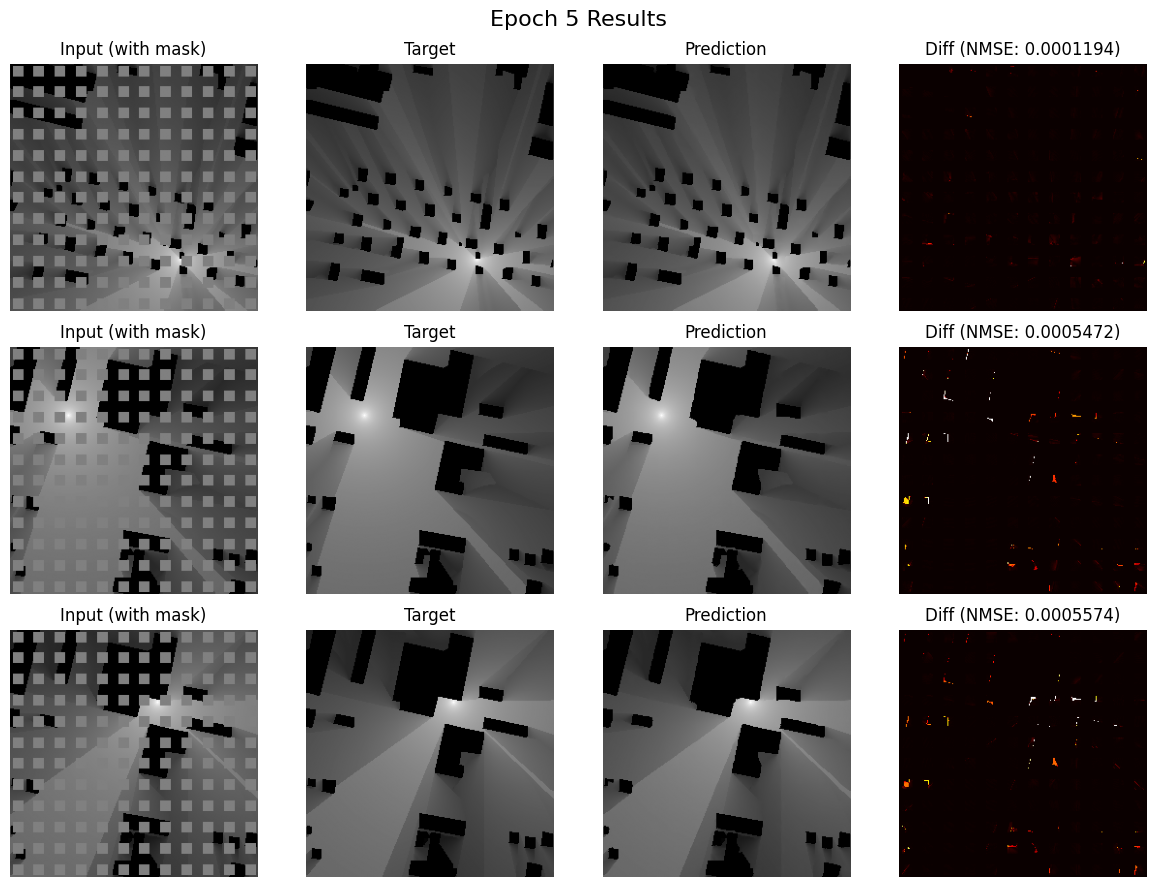

Validation: 100%|██████████| 614/614 [00:13<00:00, 47.12it/s]



Epoch 6/50
Train - Loss: 0.0006433, NMSE: 4.535e-05
Valid - Loss: 0.001538, NMSE: 0.0005868
Learning Rate: 2.80e-04
✓ 保存最佳模型 (改进: 1.364e-05)
最佳NMSE: 0.0005868 (Epoch 6)
Patience: 0/15


Validation: 100%|██████████| 614/614 [00:13<00:00, 47.10it/s]



Epoch 7/50
Train - Loss: 0.0006104, NMSE: 4.02e-05
Valid - Loss: 0.001456, NMSE: 0.0005844
Learning Rate: 3.72e-04
✓ 保存最佳模型 (改进: 2.345e-06)
最佳NMSE: 0.0005844 (Epoch 7)
Patience: 0/15


Validation: 100%|██████████| 614/614 [00:13<00:00, 46.74it/s]



Epoch 8/50
Train - Loss: 0.0005771, NMSE: 3.624e-05
Valid - Loss: 0.001428, NMSE: 0.0005645
Learning Rate: 4.70e-04
✓ 保存最佳模型 (改进: 1.988e-05)
最佳NMSE: 0.0005645 (Epoch 8)
Patience: 0/15


Validation: 100%|██████████| 614/614 [00:12<00:00, 47.49it/s]



Epoch 9/50
Train - Loss: 0.0005534, NMSE: 3.229e-05
Valid - Loss: 0.001387, NMSE: 0.0005631
Learning Rate: 5.70e-04
✓ 保存最佳模型 (改进: 1.465e-06)
最佳NMSE: 0.0005631 (Epoch 9)
Patience: 0/15


Validation: 100%|██████████| 614/614 [00:12<00:00, 47.32it/s]



Epoch 10/50
Train - Loss: 0.000536, NMSE: 2.923e-05
Valid - Loss: 0.001474, NMSE: 0.0005532
Learning Rate: 6.68e-04
✓ 保存最佳模型 (改进: 9.912e-06)
最佳NMSE: 0.0005532 (Epoch 10)
Patience: 0/15


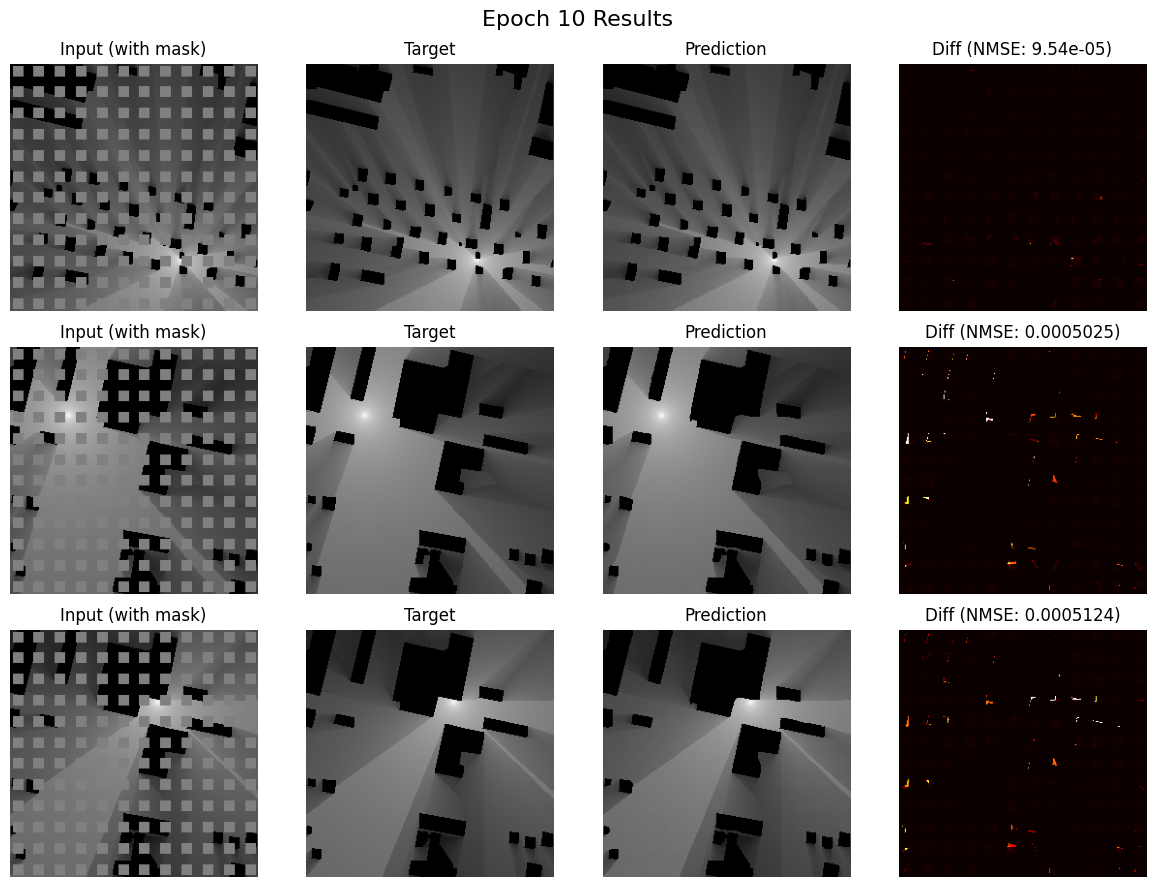

Validation: 100%|██████████| 614/614 [00:12<00:00, 47.27it/s]



Epoch 11/50
Train - Loss: 0.0005151, NMSE: 2.634e-05
Valid - Loss: 0.001404, NMSE: 0.000565
Learning Rate: 7.60e-04
最佳NMSE: 0.0005532 (Epoch 10)
Patience: 1/15


Validation: 100%|██████████| 614/614 [00:12<00:00, 47.24it/s]



Epoch 12/50
Train - Loss: 0.0005037, NMSE: 2.412e-05
Valid - Loss: 0.001458, NMSE: 0.0005554
Learning Rate: 8.41e-04
最佳NMSE: 0.0005532 (Epoch 10)
Patience: 2/15


Validation: 100%|██████████| 614/614 [00:13<00:00, 47.16it/s]



Epoch 13/50
Train - Loss: 0.0004855, NMSE: 2.096e-05
Valid - Loss: 0.001351, NMSE: 0.0005559
Learning Rate: 9.08e-04
最佳NMSE: 0.0005532 (Epoch 10)
Patience: 3/15


Validation: 100%|██████████| 614/614 [00:12<00:00, 47.56it/s]



Epoch 14/50
Train - Loss: 0.0004741, NMSE: 1.993e-05
Valid - Loss: 0.001324, NMSE: 0.0005428
Learning Rate: 9.59e-04
✓ 保存最佳模型 (改进: 1.036e-05)
最佳NMSE: 0.0005428 (Epoch 14)
Patience: 0/15


Validation: 100%|██████████| 614/614 [00:12<00:00, 47.54it/s]



Epoch 15/50
Train - Loss: 0.0004622, NMSE: 1.771e-05
Valid - Loss: 0.001379, NMSE: 0.0005438
Learning Rate: 9.90e-04
最佳NMSE: 0.0005428 (Epoch 14)
Patience: 1/15


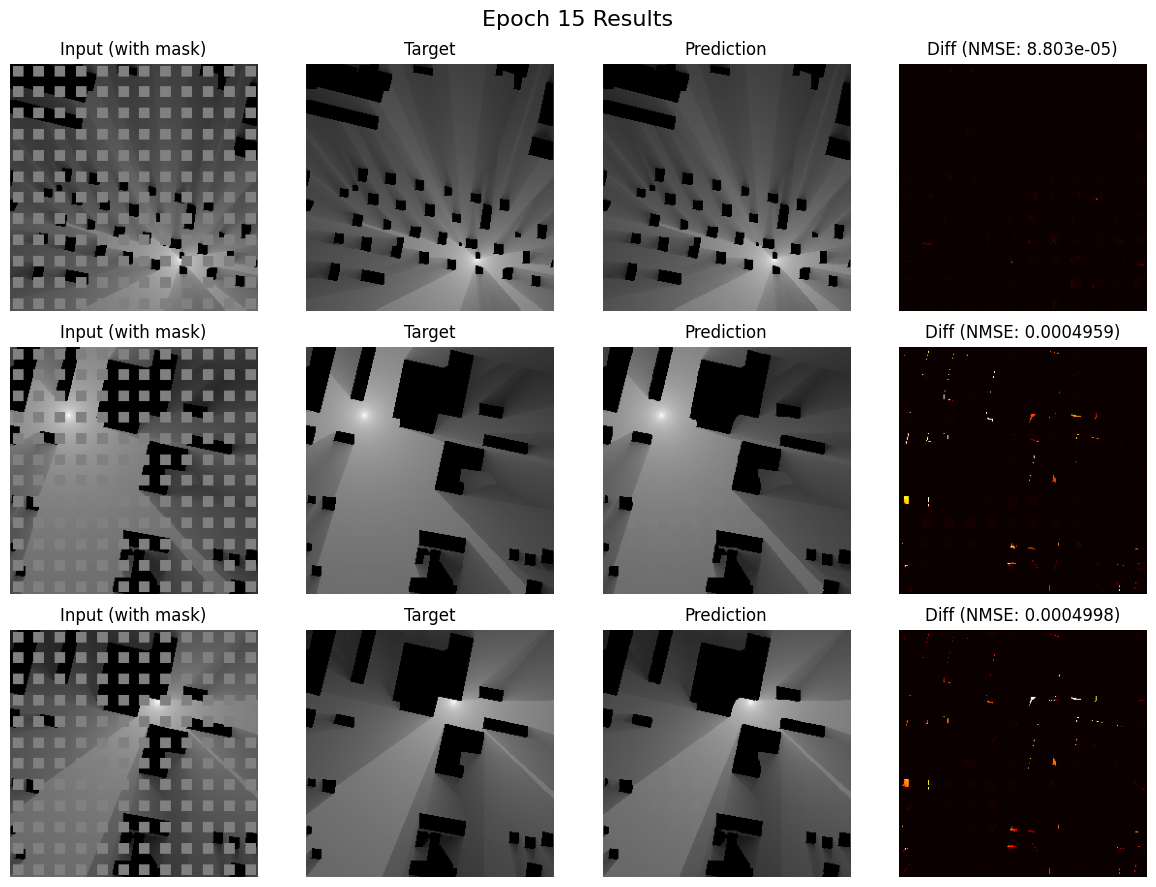

Validation: 100%|██████████| 614/614 [00:12<00:00, 47.32it/s]



Epoch 16/50
Train - Loss: 0.0004502, NMSE: 1.625e-05
Valid - Loss: 0.00155, NMSE: 0.0005677
Learning Rate: 1.00e-03
最佳NMSE: 0.0005428 (Epoch 14)
Patience: 2/15


Validation: 100%|██████████| 614/614 [00:12<00:00, 47.42it/s]



Epoch 17/50
Train - Loss: 0.0004386, NMSE: 1.452e-05
Valid - Loss: 0.00138, NMSE: 0.000547
Learning Rate: 9.98e-04
最佳NMSE: 0.0005428 (Epoch 14)
Patience: 3/15


Validation: 100%|██████████| 614/614 [00:12<00:00, 47.35it/s]



Epoch 18/50
Train - Loss: 0.0004341, NMSE: 1.425e-05
Valid - Loss: 0.001262, NMSE: 0.0005359
Learning Rate: 9.92e-04
✓ 保存最佳模型 (改进: 6.871e-06)
最佳NMSE: 0.0005359 (Epoch 18)
Patience: 0/15


Validation: 100%|██████████| 614/614 [00:12<00:00, 47.37it/s]



Epoch 19/50
Train - Loss: 0.0004238, NMSE: 1.322e-05
Valid - Loss: 0.001339, NMSE: 0.0005484
Learning Rate: 9.82e-04
最佳NMSE: 0.0005359 (Epoch 18)
Patience: 1/15


Validation: 100%|██████████| 614/614 [00:13<00:00, 46.96it/s]



Epoch 20/50
Train - Loss: 0.0004198, NMSE: 1.229e-05
Valid - Loss: 0.001242, NMSE: 0.0005349
Learning Rate: 9.68e-04
✓ 保存最佳模型 (改进: 1.032e-06)
最佳NMSE: 0.0005349 (Epoch 20)
Patience: 0/15


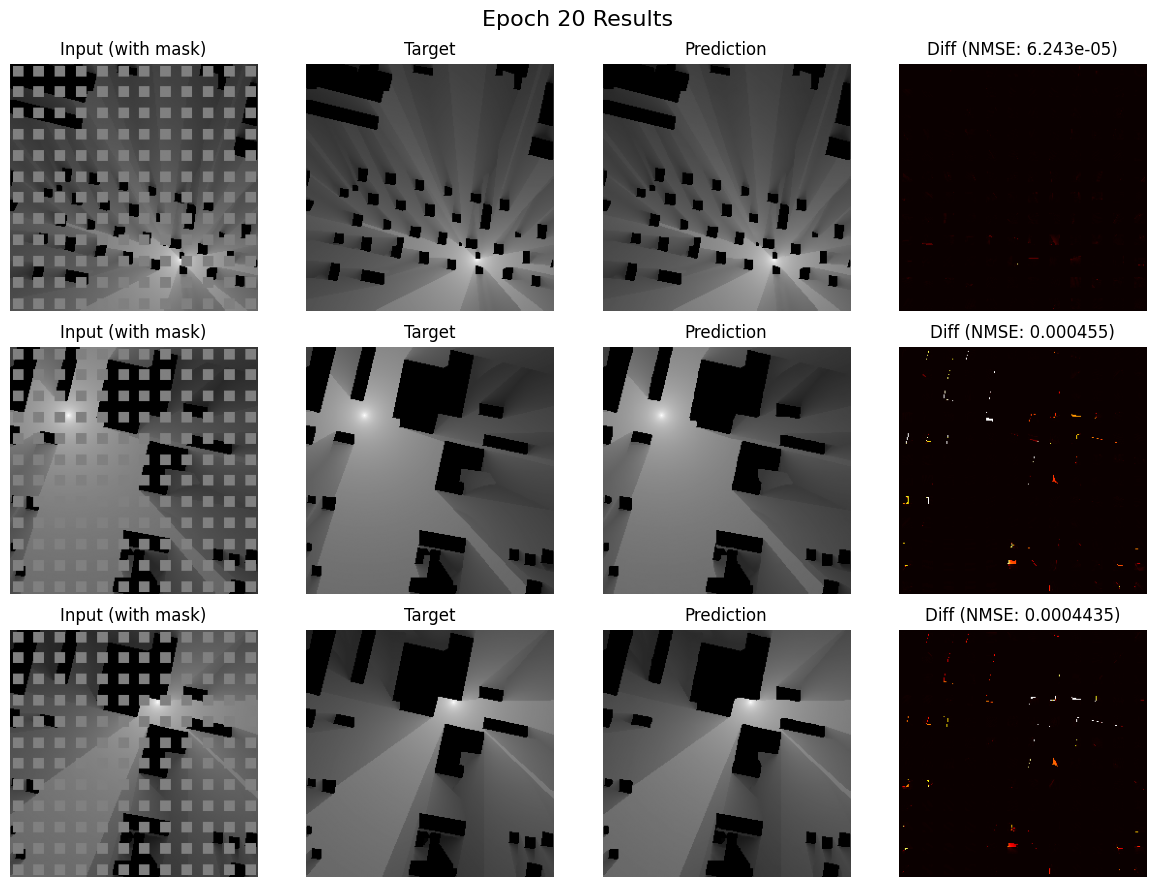

Validation: 100%|██████████| 614/614 [00:12<00:00, 47.36it/s]



Epoch 21/50
Train - Loss: 0.0004113, NMSE: 1.166e-05
Valid - Loss: 0.001419, NMSE: 0.0005461
Learning Rate: 9.50e-04
最佳NMSE: 0.0005349 (Epoch 20)
Patience: 1/15


Epoch 22/50: 100%|█████████▉| 5513/5521 [06:26<00:00, 14.31it/s, Loss=0.0004056, NMSE=1.011e-05]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Validation: 100%|██████████| 614/614 [00:13<00:00, 46.72it/s]



Epoch 36/50
Train - Loss: 0.0003548, NMSE: 6.959e-06
Valid - Loss: 0.001241, NMSE: 0.000536
Learning Rate: 3.89e-04
最佳NMSE: 0.0005289 (Epoch 32)
Patience: 4/15


Validation: 100%|██████████| 614/614 [00:13<00:00, 47.13it/s]



Epoch 37/50
Train - Loss: 0.0003546, NMSE: 6.856e-06
Valid - Loss: 0.001216, NMSE: 0.000534
Learning Rate: 3.45e-04
最佳NMSE: 0.0005289 (Epoch 32)
Patience: 5/15


Validation: 100%|██████████| 614/614 [00:13<00:00, 46.83it/s]



Epoch 38/50
Train - Loss: 0.0003519, NMSE: 6.728e-06
Valid - Loss: 0.001254, NMSE: 0.0005394
Learning Rate: 3.03e-04
最佳NMSE: 0.0005289 (Epoch 32)
Patience: 6/15


Validation: 100%|██████████| 614/614 [00:12<00:00, 47.45it/s]



Epoch 39/50
Train - Loss: 0.0003486, NMSE: 6.626e-06
Valid - Loss: 0.001311, NMSE: 0.0005359
Learning Rate: 2.63e-04
最佳NMSE: 0.0005289 (Epoch 32)
Patience: 7/15


Validation: 100%|██████████| 614/614 [00:13<00:00, 47.10it/s]



Epoch 40/50
Train - Loss: 0.0003487, NMSE: 6.566e-06
Valid - Loss: 0.001233, NMSE: 0.000533
Learning Rate: 2.25e-04
最佳NMSE: 0.0005289 (Epoch 32)
Patience: 8/15


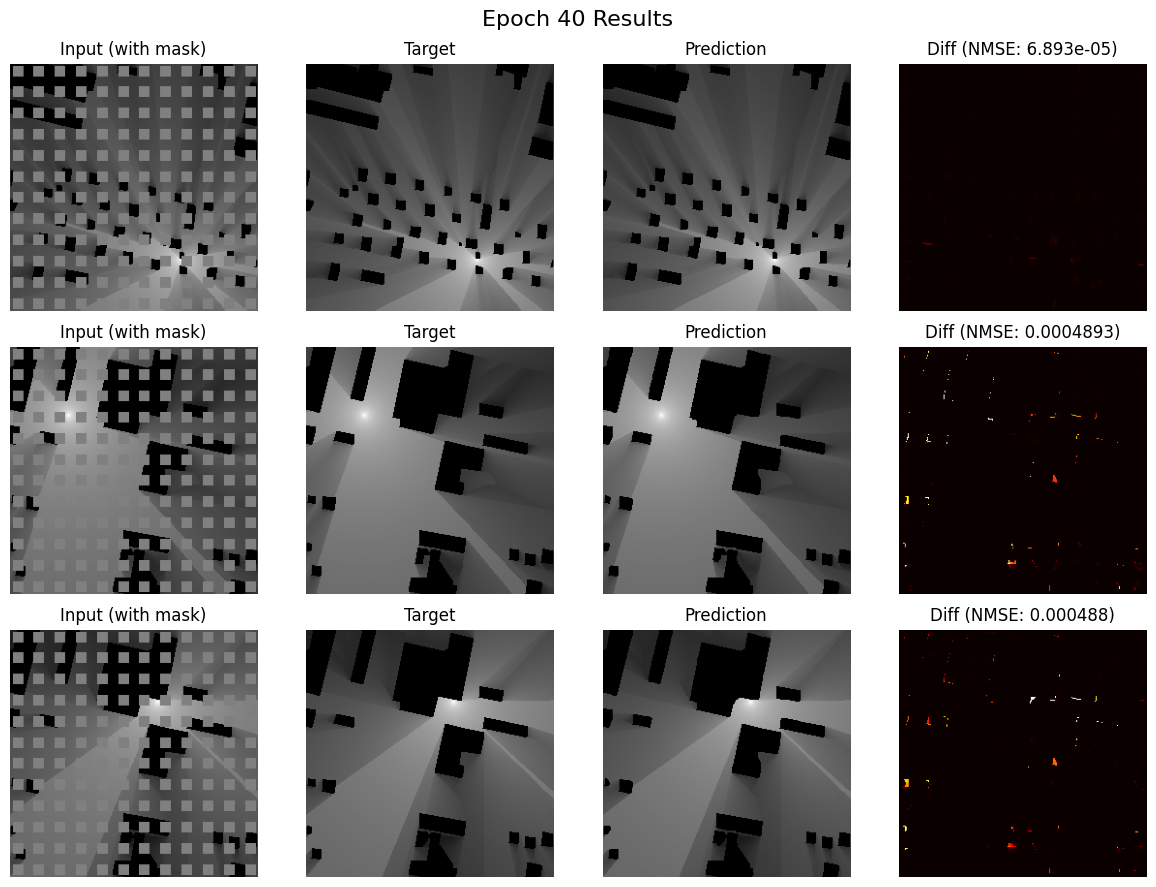

Validation: 100%|██████████| 614/614 [00:12<00:00, 47.63it/s]



Epoch 41/50
Train - Loss: 0.0003455, NMSE: 6.445e-06
Valid - Loss: 0.001215, NMSE: 0.0005337
Learning Rate: 1.88e-04
最佳NMSE: 0.0005289 (Epoch 32)
Patience: 9/15


Validation: 100%|██████████| 614/614 [00:13<00:00, 46.90it/s]



Epoch 42/50
Train - Loss: 0.0003462, NMSE: 6.404e-06
Valid - Loss: 0.001234, NMSE: 0.0005389
Learning Rate: 1.54e-04
最佳NMSE: 0.0005289 (Epoch 32)
Patience: 10/15


Validation: 100%|██████████| 614/614 [00:12<00:00, 47.23it/s]



Epoch 43/50
Train - Loss: 0.0003431, NMSE: 6.313e-06
Valid - Loss: 0.001221, NMSE: 0.0005374
Learning Rate: 1.23e-04
最佳NMSE: 0.0005289 (Epoch 32)
Patience: 11/15


Validation: 100%|██████████| 614/614 [00:13<00:00, 46.83it/s]



Epoch 44/50
Train - Loss: 0.0003431, NMSE: 6.28e-06
Valid - Loss: 0.00123, NMSE: 0.0005384
Learning Rate: 9.55e-05
最佳NMSE: 0.0005289 (Epoch 32)
Patience: 12/15


Validation: 100%|██████████| 614/614 [00:13<00:00, 47.20it/s]



Epoch 45/50
Train - Loss: 0.0003433, NMSE: 6.258e-06
Valid - Loss: 0.001226, NMSE: 0.000536
Learning Rate: 7.08e-05
最佳NMSE: 0.0005289 (Epoch 32)
Patience: 13/15


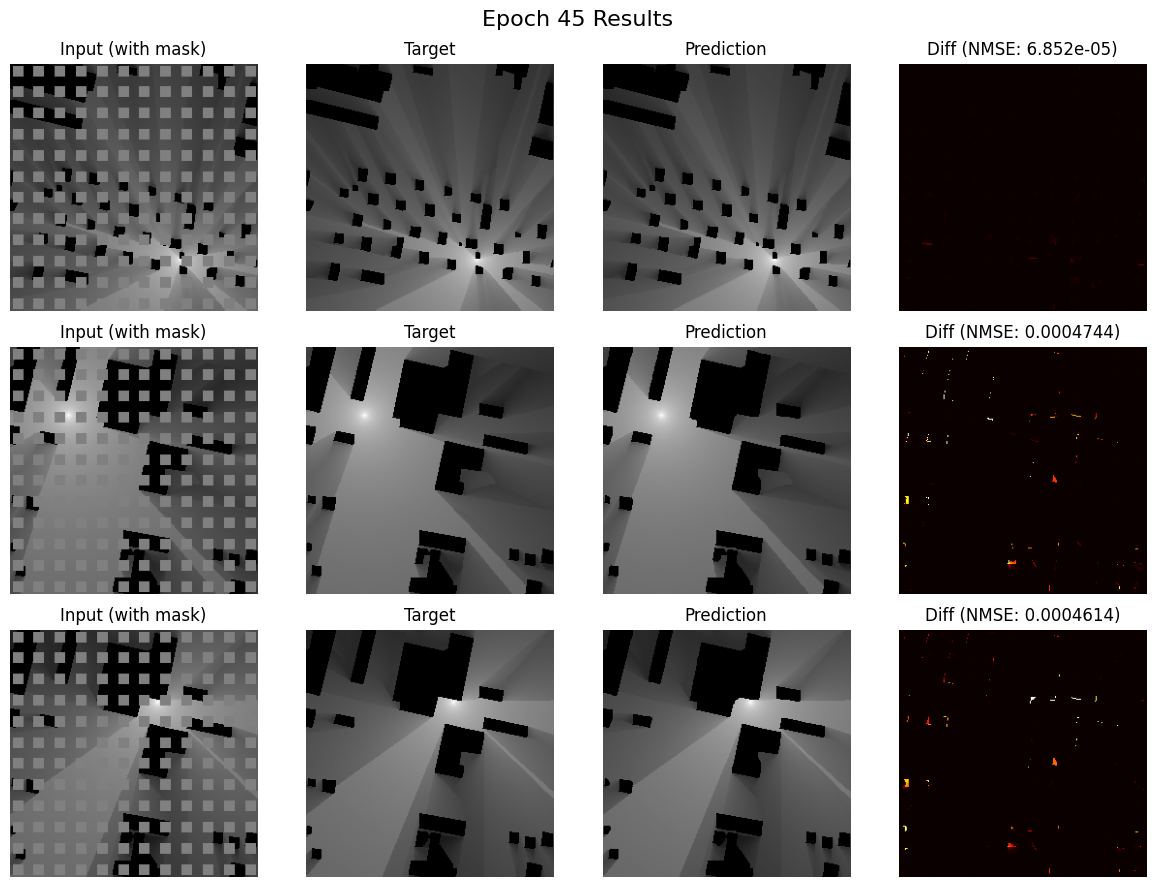

Validation: 100%|██████████| 614/614 [00:13<00:00, 46.41it/s]



Epoch 46/50
Train - Loss: 0.0003412, NMSE: 6.202e-06
Valid - Loss: 0.001242, NMSE: 0.000539
Learning Rate: 4.95e-05
最佳NMSE: 0.0005289 (Epoch 32)
Patience: 14/15


Validation: 100%|██████████| 614/614 [00:13<00:00, 47.12it/s]


Epoch 47/50
Train - Loss: 0.0003417, NMSE: 6.198e-06
Valid - Loss: 0.001244, NMSE: 0.0005368
Learning Rate: 3.19e-05

早停: 验证NMSE已经15轮没有改善

训练完成!
最佳模型: Epoch 32
最佳验证NMSE: 0.0005289


In [8]:
# 初始化模型
model = ImprovedUNet(
    in_channels=1,
    out_channels=1,
    features=config.features
)
model = model.to(device)

# 损失函数
criterion = CombinedLoss(
    l1_weight=config.l1_weight,
    l2_weight=config.l2_weight,
    ssim_weight=config.ssim_weight
)

# 优化器
optimizer = optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

# 学习率调度器 - OneCycleLR
total_steps = len(train_loader) * config.epochs
scheduler = OneCycleLR(
    optimizer,
    max_lr=config.learning_rate,
    total_steps=total_steps,
    pct_start=0.3,
    anneal_strategy='cos'
)

# 训练历史
history = {
    'train_loss': [],
    'train_nmse': [],
    'val_loss': [],
    'val_nmse': [],
    'lr': []
}

best_val_nmse = float('inf')
best_epoch = 0
patience_counter = 0

print("="*70)
print("开始训练 UNet 模型...")
print(f"总训练轮数: {config.epochs}")
print(f"批量大小: {config.batch_size}")
print(f"初始学习率: {config.learning_rate}")
print("训练使用固定的144个遮罩位置（与测试集一致）")
print("="*70)

for epoch in range(1, config.epochs + 1):
    # 获取当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    history['lr'].append(current_lr)
    
    # 训练（传递scheduler参数）
    train_loss, train_nmse = train_epoch(
        model, train_loader, criterion, optimizer, scheduler, device, epoch, config
    )
    
    history['train_loss'].append(train_loss)
    history['train_nmse'].append(train_nmse)
    
    # 验证
    if epoch % config.val_interval == 0:
        val_loss, val_nmse = validate(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_nmse'].append(val_nmse)
        
        print(f"\n{'='*70}")
        print(f"Epoch {epoch}/{config.epochs}")
        print(f"Train - Loss: {train_loss:.4g}, NMSE: {train_nmse:.4g}")
        print(f"Valid - Loss: {val_loss:.4g}, NMSE: {val_nmse:.4g}")
        print(f"Learning Rate: {current_lr:.2e}")
        
        # 保存最佳模型
        if val_nmse < best_val_nmse:
            improvement = best_val_nmse - val_nmse
            best_val_nmse = val_nmse
            best_epoch = epoch
            patience_counter = 0
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_nmse': val_nmse,
            }, os.path.join(MODEL_PATH, 'best_model.pth'))
            print(f"✓ 保存最佳模型 (改进: {improvement:.4g})")
        else:
            patience_counter += 1
            if patience_counter >= config.patience:
                print(f"\n早停: 验证NMSE已经{config.patience}轮没有改善")
                break
        
        print(f"最佳NMSE: {best_val_nmse:.4g} (Epoch {best_epoch})")
        print(f"Patience: {patience_counter}/{config.patience}")
        print("="*70)
        
        # 可视化（每5轮）
        if epoch % config.vis_interval == 0:
            visualize_results(model, val_loader, device, epoch, num_samples=3)
    
    # 定期保存检查点
    if epoch % config.save_interval == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history,
        }, os.path.join(MODEL_PATH, f'checkpoint_epoch_{epoch}.pth'))

print(f"\n训练完成!")
print(f"最佳模型: Epoch {best_epoch}")
print(f"最佳验证NMSE: {best_val_nmse:.4g}")

## 9. 绘制训练曲线

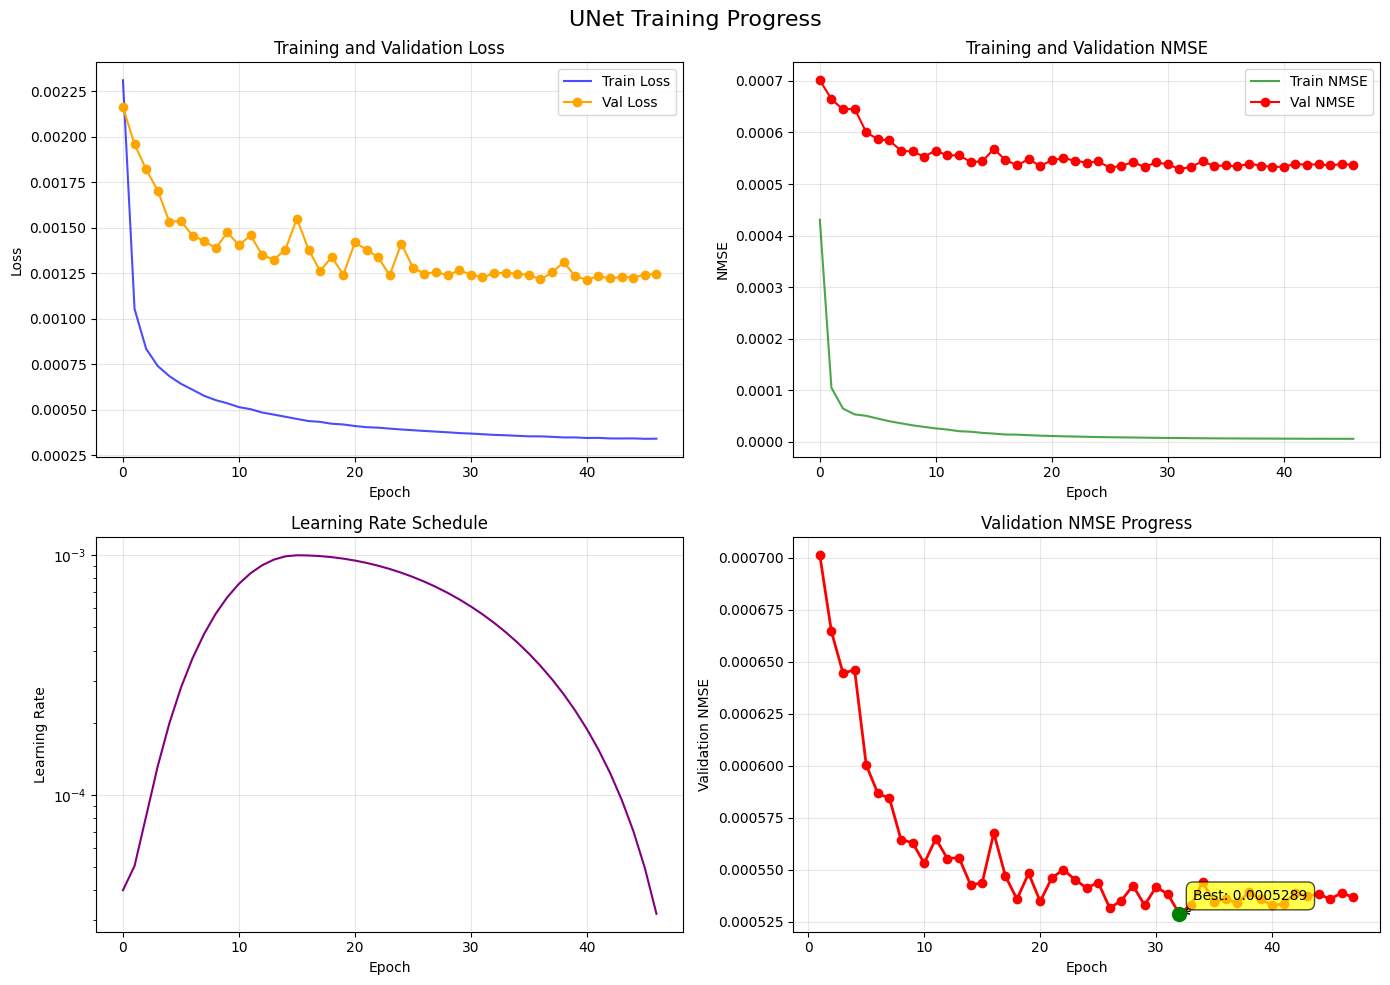


训练总结:
最终训练NMSE: 6.198e-06
最终验证NMSE: 0.0005368
最佳验证NMSE: 0.0005289


In [9]:
# 绘制训练曲线
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 损失曲线
axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue', alpha=0.7)
if history['val_loss']:
    axes[0, 0].plot(np.arange(config.val_interval-1, len(history['train_loss']), config.val_interval), 
                    history['val_loss'], label='Val Loss', marker='o', color='orange')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# NMSE曲线
axes[0, 1].plot(history['train_nmse'], label='Train NMSE', color='green', alpha=0.7)
if history['val_nmse']:
    axes[0, 1].plot(np.arange(config.val_interval-1, len(history['train_nmse']), config.val_interval), 
                    history['val_nmse'], label='Val NMSE', marker='o', color='red')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('NMSE')
axes[0, 1].set_title('Training and Validation NMSE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 学习率曲线
axes[1, 0].plot(history['lr'], color='purple')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# 验证NMSE详细视图
if history['val_nmse']:
    epochs_val = np.arange(config.val_interval, len(history['train_nmse'])+1, config.val_interval)
    axes[1, 1].plot(epochs_val[:len(history['val_nmse'])], history['val_nmse'], 
                    marker='o', color='red', linewidth=2, markersize=6)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Validation NMSE')
    axes[1, 1].set_title('Validation NMSE Progress')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 标记最佳点
    if history['val_nmse']:
        best_idx = np.argmin(history['val_nmse'])
        best_epoch_val = epochs_val[best_idx]
        best_nmse_val = history['val_nmse'][best_idx]
        axes[1, 1].scatter(best_epoch_val, best_nmse_val, color='green', s=100, zorder=5)
        axes[1, 1].annotate(f'Best: {best_nmse_val:.4g}', 
                           xy=(best_epoch_val, best_nmse_val),
                           xytext=(10, 10), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.suptitle('UNet Training Progress', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'training_curves.png'), dpi=150)
plt.show()

print(f"\n训练总结:")
print(f"最终训练NMSE: {history['train_nmse'][-1]:.4g}")
if history['val_nmse']:
    print(f"最终验证NMSE: {history['val_nmse'][-1]:.4g}")
    print(f"最佳验证NMSE: {min(history['val_nmse']):.4g}")

## 10. 测试集预测和评估

In [10]:
# 加载最佳模型
checkpoint = torch.load(os.path.join(MODEL_PATH, 'best_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
print(f"加载最佳模型 (Epoch {checkpoint['epoch']}, Val NMSE: {checkpoint['val_nmse']:.4g})")

# 测试集预测
model.eval()
test_nmse_list = []

print("\n开始测试集预测...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        input_img = batch['input'].to(device)
        original_img = batch['original'].to(device)
        mask = batch['mask'].to(device)
        filename = batch['filename'][0]
        
        # 预测
        output = model(input_img)
        
        # 融合输出
        final_output = original_img * mask + output * (1 - mask)
        
        # 计算NMSE
        nmse = calculate_nmse(final_output, original_img)
        test_nmse_list.append(nmse)
        
        # 保存预测结果
        output_np = (final_output[0, 0].cpu().numpy() * 255).astype(np.uint8)
        output_img = Image.fromarray(output_np, mode='L')
        output_path = os.path.join(OUTPUT_PATH, f'pred_{filename}')
        output_img.save(output_path)

# 计算测试集统计
test_nmse_array = np.array(test_nmse_list)
print(f"\n测试集结果统计:")
print(f"平均NMSE: {np.mean(test_nmse_array):.4g}")
print(f"标准差: {np.std(test_nmse_array):.4g}")
print(f"最小NMSE: {np.min(test_nmse_array):.4g}")
print(f"最大NMSE: {np.max(test_nmse_array):.4g}")
print(f"中位数NMSE: {np.median(test_nmse_array):.4g}")
print(f"\n预测结果已保存至: {OUTPUT_PATH}")
print(f"共预测 {len(test_nmse_list)} 张图像")

加载最佳模型 (Epoch 32, Val NMSE: 0.0005289)

开始测试集预测...


Testing: 100%|██████████| 7010/7010 [01:09<00:00, 100.69it/s]



测试集结果统计:
平均NMSE: 0.1511
标准差: 0.02951
最小NMSE: 0.06644
最大NMSE: 0.2308
中位数NMSE: 0.1538

预测结果已保存至: output_unet
共预测 7010 张图像


## 11. 测试结果可视化

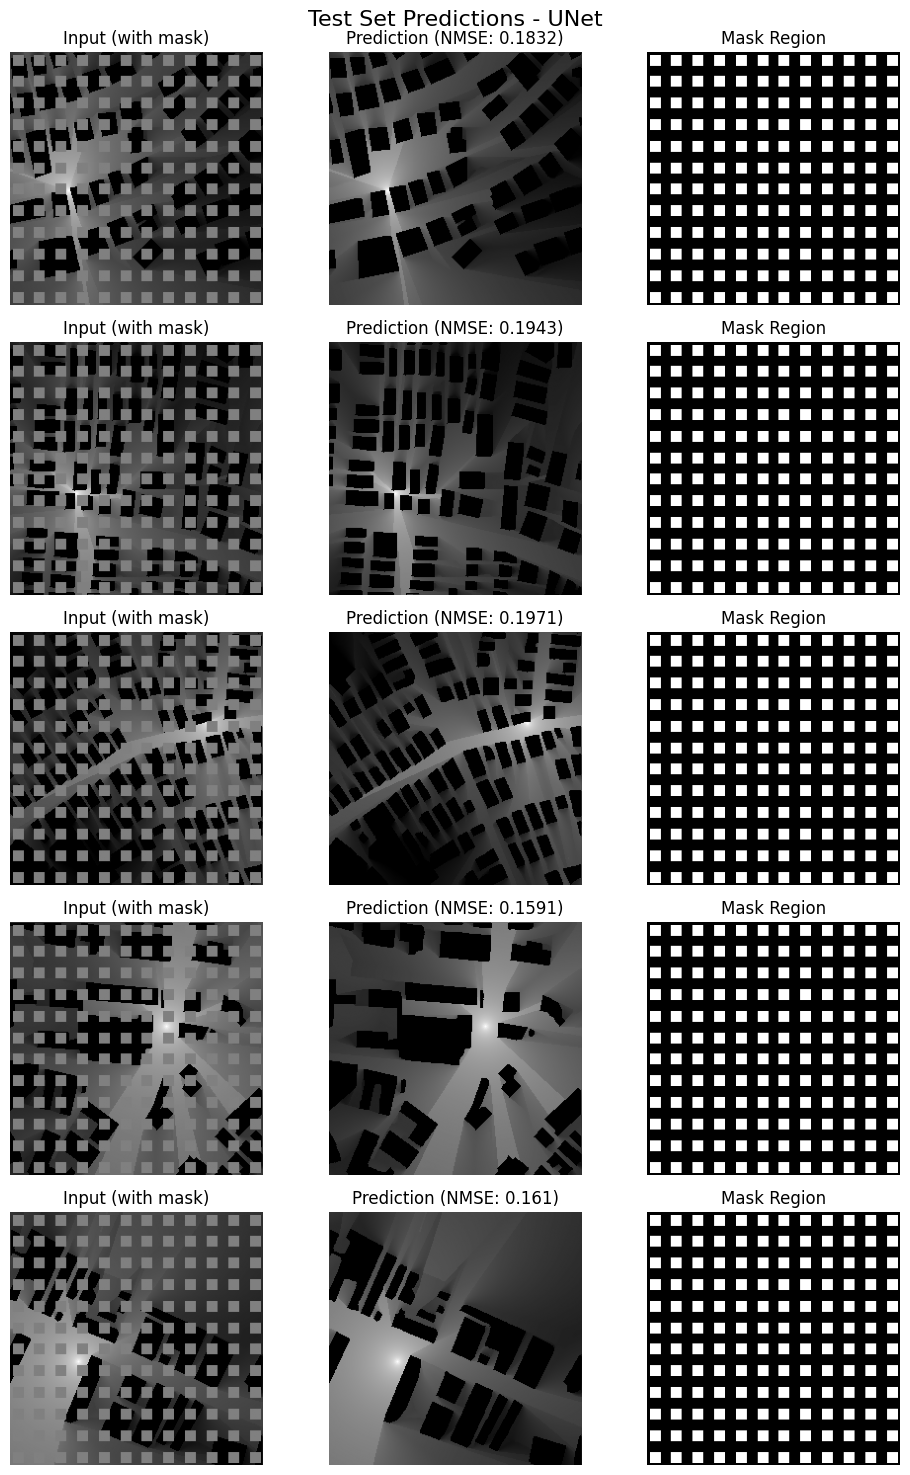

In [11]:
def visualize_test_results(test_loader, model, device, num_samples=6):
    """可视化测试集结果"""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 3*num_samples))
    
    # 随机选择样本
    indices = np.random.choice(len(test_loader), num_samples, replace=False)
    
    sample_idx = 0
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if i in indices:
                input_img = batch['input'].to(device)
                original_img = batch['original'].to(device)
                mask = batch['mask'].to(device)
                
                output = model(input_img)
                final_output = original_img * mask + output * (1 - mask)
                
                # 转换为numpy
                input_np = input_img[0, 0].cpu().numpy()
                output_np = final_output[0, 0].cpu().numpy()
                mask_np = mask[0, 0].cpu().numpy()
                
                # 计算NMSE
                nmse = calculate_nmse(final_output, original_img)
                
                # 绘制
                axes[sample_idx, 0].imshow(input_np, cmap='gray', vmin=0, vmax=1)
                axes[sample_idx, 0].set_title('Input (with mask)')
                axes[sample_idx, 0].axis('off')
                
                axes[sample_idx, 1].imshow(output_np, cmap='gray', vmin=0, vmax=1)
                axes[sample_idx, 1].set_title(f'Prediction (NMSE: {nmse:.4g})')
                axes[sample_idx, 1].axis('off')
                
                axes[sample_idx, 2].imshow(1-mask_np, cmap='gray', vmin=0, vmax=1)
                axes[sample_idx, 2].set_title('Mask Region')
                axes[sample_idx, 2].axis('off')
                
                sample_idx += 1
                if sample_idx >= num_samples:
                    break
    
    plt.suptitle('Test Set Predictions - UNet', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'test_predictions.png'), dpi=150)
    plt.show()

visualize_test_results(test_loader, model, device, num_samples=5)

## 12. 最终总结

In [12]:
print("="*70)
print("Radio Map 补全任务 - UNet 方法总结")
print("="*70)
print(f"\n模型架构特点:")
print(f"  1. 改进的UNet架构，包含注意力机制")
print(f"  2. 残差连接提升梯度流动")
print(f"  3. 多尺度特征融合")
print(f"  4. 组合损失函数 (L1 + L2)")
print(f"\n训练配置:")
print(f"  总训练轮数: {config.epochs}")
print(f"  批量大小: {config.batch_size}")
print(f"  模型特征维度: {config.features}")
print(f"  最佳验证NMSE: {best_val_nmse:.4g} (Epoch {best_epoch})")
print(f"\n模型规模:")
print(f"  参数量: {sum(p.numel() for p in model.parameters()):,}")
print(f"  训练数据: {len(train_dataset)} 张")
print(f"  验证数据: {len(val_dataset)} 张")
print(f"  测试数据: {len(test_dataset)} 张")
print(f"\n测试集性能:")
print(f"  平均NMSE: {np.mean(test_nmse_array):.4g}")
print(f"  标准差: {np.std(test_nmse_array):.4g}")
print(f"\n输出路径: {OUTPUT_PATH}")
print(f"模型路径: {MODEL_PATH}")
print("="*70)

Radio Map 补全任务 - UNet 方法总结

模型架构特点:
  1. 改进的UNet架构，包含注意力机制
  2. 残差连接提升梯度流动
  3. 多尺度特征融合
  4. 组合损失函数 (L1 + L2)

训练配置:
  总训练轮数: 50
  批量大小: 8
  模型特征维度: [64, 128, 256, 512, 1024]
  最佳验证NMSE: 0.0005289 (Epoch 32)

模型规模:
  参数量: 32,813,933
  训练数据: 44163 张
  验证数据: 4907 张
  测试数据: 7010 张

测试集性能:
  平均NMSE: 0.1511
  标准差: 0.02951

输出路径: output_unet
模型路径: models_unet
